In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

import torch
import torchtuples as tt

from pycox.datasets import metabric
from pycox.models import CoxTime
from pycox.models.cox_time import MLPVanillaCoxTime
from pycox.evaluation import EvalSurv

In [12]:
np.random.seed(1234)
_ = torch.manual_seed(123)

In [13]:
df_train = metabric.read_df()
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [14]:
df_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,duration,event
0,5.603834,7.811392,10.797988,5.967607,1.0,1.0,0.0,1.0,56.840000,99.333336,0
1,5.284882,9.581043,10.204620,5.664970,1.0,0.0,0.0,1.0,85.940002,95.733330,1
3,6.654017,5.341846,8.646379,5.655888,0.0,0.0,0.0,0.0,66.910004,239.300003,0
4,5.456747,5.339741,10.555724,6.008429,1.0,0.0,0.0,1.0,67.849998,56.933334,1
5,5.425826,6.331182,10.455145,5.749053,1.0,1.0,0.0,1.0,70.519997,123.533333,0


In [15]:
from sklearn.compose import ColumnTransformer
cols = df_train.columns.tolist()
cols.remove('event')
cols.remove('duration')

preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
)

x_train = preprocessor.fit_transform(df_train).astype('float32')
x_val = preprocessor.transform(df_val).astype('float32')
x_test = preprocessor.transform(df_test).astype('float32')

In [16]:
labtrans = CoxTime.label_transform()
get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))
durations_test, events_test = get_target(df_test)
val = tt.tuplefy(x_val, y_val)
val.shapes()

((305, 11), ((305,), (305,)))

In [17]:
val.repeat(2).cat().shapes()

((610, 11), ((610,), (610,)))

In [18]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
batch_norm = True
dropout = 0.1
net = MLPVanillaCoxTime(in_features, num_nodes, batch_norm, dropout)
net.eval()

MLPVanillaCoxTime(
  (net): MLPVanilla(
    (net): Sequential(
      (0): DenseVanillaBlock(
        (linear): Linear(in_features=12, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): DenseVanillaBlock(
        (linear): Linear(in_features=32, out_features=32, bias=True)
        (activation): ReLU()
        (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (2): Linear(in_features=32, out_features=1, bias=False)
    )
  )
)

In [19]:
model = CoxTime(net, tt.optim.Adam, labtrans=labtrans)

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


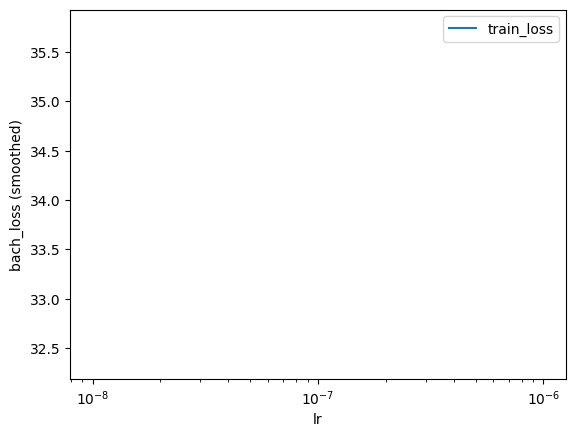

In [20]:
batch_size = 256
lrfinder = model.lr_finder(x_train, y_train, batch_size, tolerance=2)
_ = lrfinder.plot()

In [ ]:
lrfinder.get_best_lr()

np.float64(0.0001)

In [22]:
model.optimizer.set_lr(0.01)

In [23]:
epochs = 512
callbacks = [tt.callbacks.EarlyStopping()]
verbose = True

In [24]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val.repeat(10).cat())

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/torchtuples/tupletree.py:597: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
  return self.tuple_.apply(lambda x: x[index])


0:	[0s / 0s],		train_loss: 24.2245,	val_loss: 4.7856
1:	[0s / 0s],		train_loss: 0.6827,	val_loss: 0.4643
2:	[0s / 0s],		train_loss: 0.4576,	val_loss: 0.3456
3:	[0s / 0s],		train_loss: 0.3652,	val_loss: 0.2869
4:	[0s / 0s],		train_loss: 0.3196,	val_loss: 0.2667
5:	[0s / 0s],		train_loss: 0.2624,	val_loss: 0.2298
6:	[0s / 0s],		train_loss: 0.2581,	val_loss: 0.2158
7:	[0s / 0s],		train_loss: 0.2297,	val_loss: 0.2033
8:	[0s / 0s],		train_loss: 0.2188,	val_loss: 0.1857
9:	[0s / 0s],		train_loss: 0.2161,	val_loss: 0.1796
10:	[0s / 0s],		train_loss: 0.1946,	val_loss: 0.1574
11:	[0s / 0s],		train_loss: 0.1891,	val_loss: 0.1472
12:	[0s / 0s],		train_loss: 0.1766,	val_loss: 0.1392
13:	[0s / 0s],		train_loss: 0.1840,	val_loss: 0.1413
14:	[0s / 0s],		train_loss: 0.1643,	val_loss: 0.1308
15:	[0s / 0s],		train_loss: 0.1570,	val_loss: 0.1190
16:	[0s / 0s],		train_loss: 0.1587,	val_loss: 0.1144
17:	[0s / 0s],		train_loss: 0.1464,	val_loss: 0.1099
18:	[0s / 0s],		train_loss: 0.1313,	val_loss: 0.1212
19

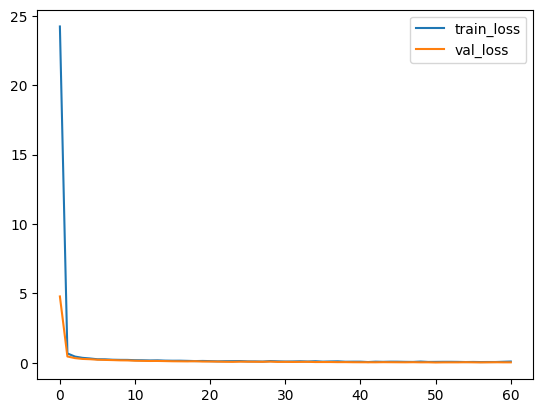

In [25]:
_ = log.plot()

In [26]:
model.partial_log_likelihood(*val).mean()

np.float32(-2.1025147)

In [27]:
_ = model.compute_baseline_hazards()

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/pycox/models/cox_time.py:86: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((sub, t), batch_size, True, eval_, num_workers=num_workers)).flatten().sum()


In [29]:
surv = model.predict_surv_df(x_test)
surv

/media/datos/WORKSPACE/DOCTORADO/cdm_prototype/.venv/lib/python3.10/site-packages/pycox/models/cox_time.py:118: RuntimeWarning: overflow encountered in exp
  return np.exp(self.predict((input, t), batch_size, True, eval_, num_workers=num_workers)).flatten()


,0,1,2,3,4,5,6,7,8,9,...,371,372,373,374,375,376,377,378,379,380
0.100000,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
0.766667,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
1.233333,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
1.266667,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
1.433333,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.000000e+00,1.0,1.0,1.0,...,1.0,1.0,1.0,1.000000e+00,1.000000e+00,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335.600006,0.0,0.0,4.808109e-03,5.201307e-23,0.0,0.0,7.323869e-02,0.0,0.0,0.0,...,0.0,0.0,0.0,1.193190e-05,1.769819e-02,0.0,0.0,0.0,0.0,0.0
335.733337,0.0,0.0,2.590868e-05,1.380980e-45,0.0,0.0,5.693016e-03,0.0,0.0,0.0,...,0.0,0.0,0.0,1.721903e-10,3.410058e-04,0.0,0.0,0.0,0.0,0.0
337.033325,0.0,0.0,2.590868e-05,1.380980e-45,0.0,0.0,5.693016e-03,0.0,0.0,0.0,...,0.0,0.0,0.0,1.721903e-10,3.410058e-04,0.0,0.0,0.0,0.0,0.0
351.000000,0.0,0.0,8.654907e-12,3.585231e-115,0.0,0.0,3.874749e-06,0.0,0.0,0.0,...,0.0,0.0,0.0,1.325348e-24,4.328283e-09,0.0,0.0,0.0,0.0,0.0
